<a href="https://colab.research.google.com/github/Brmiranda10/price_prediction/blob/main/Spark_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing

In [ ]:
!pip install -q pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# Imports

In [ ]:
from pyspark.sql import SparkSession
from google.colab import drive
import zipfile
from pyspark.sql import functions as f
from pyspark.sql.types import DoubleType, StringType, IntegerType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Spark session

In [ ]:
spark = SparkSession.builder \
  .master('local[*]') \
  .appName('Spark Regression') \
  .getOrCreate()
spark

# Loading the data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zipfile.ZipFile('/content/drive/MyDrive/Spark_alura_course_5/aula01.zip', 'r').extractall('/content/drive/MyDrive/Spark_alura_course_5')

In [ ]:
data = spark.read.json('/content/drive/MyDrive/Spark_alura_course_5/aula01/imoveis.json')

In [ ]:
data.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [ ]:
data.count()

73615

# Features selection

In [ ]:
data.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [ ]:
data \
  .select('ident.customerID', 'listing.*') \
  .show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [ ]:
data \
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*') \
  .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [ ]:
data \
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*') \
  .drop('city', 'location', 'totalAreas') \
  .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [ ]:
data_set = data \
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*') \
  .drop('city', 'location', 'totalAreas')

In [ ]:
data_set.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-----+-----+----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-----+-----+----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000|  150|   0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000|  120|   0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|        0|            

# Data processing

In [ ]:
data_set.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [ ]:
data_set = data_set\
    .withColumn('usableAreas', data_set['usableAreas'].cast(IntegerType())) \
    .withColumn('price', data_set['price'].cast(DoubleType())) \
    .withColumn('condo', data_set['condo'].cast(DoubleType())) \
    .withColumn('iptu', data_set['iptu'].cast(DoubleType()))

data_set.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: integer (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [ ]:
data_set \
  .select('zone') \
  .groupBy('zone') \
  .count() \
  .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|15191|
|  Zona Oeste|37116|
|Zona Central| 1921|
|    Zona Sul|19222|
|            |  165|
+------------+-----+



In [ ]:
data_set.select([f.count(f.when(f.isnull(c) | f.isnull(c), 1)).alias(c) for c in data_set.columns]).show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0| 6504|9116|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [ ]:
data_set \
  .select('*') \
  .na \
  .fill(0) \
  .show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|  iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|  Zona Oeste|45000.0|120.0|   0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|  

In [ ]:
data_set = data_set \
  .select('*') \
  .na \
  .fill(0)

In [ ]:
data_set.count()

73615

In [ ]:
data_set.select([f.count(f.when(f.isnull(c) | f.isnull(c), 1)).alias(c) for c in data_set.columns]).show()

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|         0|   0|    0|        0|       0|     0|            0|     0|        0|              0|          0|           0|   0|    0|    0|   0|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [ ]:
data_set = data_set \
    .where(f.col('zone') != '')

In [ ]:
data_set \
  .select('zone') \
  .groupBy('zone') \
  .count() \
  .show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|15191|
|  Zona Oeste|37116|
|Zona Central| 1921|
|    Zona Sul|19222|
+------------+-----+



## Dummy variables

In [ ]:
data_set.show(5)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+----------+-------+-----+-----+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|      zone|  price|condo| iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+----------+-------+-----+-----+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|Zona Oeste|45000.0|150.0|  0.0|
|660895-AUENKNYY|Apartamento|Residencial|        1|       2|     0|            1|     0|        0|              0|         44|          Santíssimo|Zona Oeste|45000.0|120.0|  0.0|
|751522-JESYFEQL|     Outros|Residencial|        0|       0|     0|            0|     0|        0|       

In [ ]:
data_set \
  .groupBy('customerID') \
  .pivot('unit') \
  .agg(f.lit(1)) \
  .na \
  .fill(0) \
  .show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [ ]:
unit = data_set \
  .groupBy('customerID') \
  .pivot('unit') \
  .agg(f.lit(1)) \
  .na \
  .fill(0)

In [ ]:
data_set \
  .groupBy('customerID') \
  .pivot('zone') \
  .agg(f.lit(1)) \
  .na \
  .fill(0) \
  .show()

+---------------+------------+----------+----------+--------+
|     customerID|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+------------+----------+----------+--------+
|336149-TMGGYSKN|           0|         0|         1|       0|
|846345-JYHIIHQM|           0|         1|         0|       0|
|598128-VUMFFGPB|           0|         0|         0|       1|
|368553-OPCVLPHJ|           0|         1|         0|       0|
|549743-AXHKZBFK|           0|         0|         1|       0|
|812359-OJYBIPJI|           0|         0|         0|       1|
|660235-HZGMOQSM|           0|         0|         1|       0|
|060113-BUDVVMLJ|           0|         0|         1|       0|
|414450-LWZHERNQ|           0|         0|         1|       0|
|002985-MNHDTPVG|           0|         0|         1|       0|
|849580-WTTBUJKK|           0|         1|         0|       0|
|869294-GMGUYRPI|           0|         0|         1|       0|
|744421-IZJWISWB|           0|         0|         1|       0|
|046476-

In [ ]:
zone = data_set \
  .groupBy('customerID') \
  .pivot('zone') \
  .agg(f.lit(1)) \
  .na \
  .fill(0)

In [ ]:
data_set = data_set \
  .join(unit, 'customerID', how='inner') \
  .join(zone, 'customerID', how='inner')

In [ ]:
data_set.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo|  iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|          0|   0|     1|           0|         0|         1|       0|


## Data vectorizer

In [ ]:
# renaming the column 'price' to 'label'. label is what we want to predict.
data_set = data_set.withColumnRenamed('price', 'label')

In [ ]:
# explanation variables
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]


In [ ]:
# vectorization. Transform all columns in X to a unique column called 'features'
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
data_set.show(5)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|      zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+----------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660895-AUEN

In [ ]:
# We have created a new data_set with the features and labels.
data_set_prep = assembler.transform(data_set).select('features', 'label')

In [ ]:
data_set_prep.show(truncate=False, n=5)

+--------------------------------------------------------------------------+-------+
|features                                                                  |label  |
+--------------------------------------------------------------------------+-------+
|(17,[3,7,8,12,15],[1.0,62.0,150.0,1.0,1.0])                               |45000.0|
|(17,[0,1,3,7,8,10,15],[1.0,2.0,1.0,44.0,120.0,1.0,1.0])                   |45000.0|
|(17,[7,8,12,15],[132.0,100.0,1.0,1.0])                                    |50000.0|
|(17,[0,5,7,8,9,12,14],[1.0,3.0,32.0,468.0,346.0,1.0,1.0])                 |45000.0|
|[2.0,3.0,3.0,1.0,1.0,2.0,4.0,60.0,400.0,120.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0]|50000.0|
+--------------------------------------------------------------------------+-------+
only showing top 5 rows



# Data Exploration

In [ ]:
# collect function brings the results to into the correlation objetc
correlation = Correlation.corr(data_set_prep, 'features').collect()
correlation

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6561, -0.0383, 0.4045, 0.738, 0.0071, -0.0985, 0.563, ..., 0.0068, 0.1782, -0.172, -0.0532, -0.0976, -0.304, -0.6017, 1.0], False))]

We have to generate a dense array with multiple values.
There are two main types of matrices, sparse and dense.
In the sparse matrix, zeros are not represented. Rather than having zero, there is simply no representation. It is a null value.
In the dense matrix, however, we have zeros represented, so where we would have null values, we have zero.

In [ ]:
# taking only the pearson correlation
correlation = Correlation.corr(data_set_prep, 'features').collect()[0][0]
correlation

DenseMatrix(17, 17, [1.0, 0.6561, -0.0383, 0.4045, 0.738, 0.0071, -0.0985, 0.563, ..., 0.0068, 0.1782, -0.172, -0.0532, -0.0976, -0.304, -0.6017, 1.0], False)

But, it's not so easy to work with dense matrices, so let's bring this matrix to an array, which is an easier way to work

In [ ]:
correlation.toArray()

array([[ 1.00000000e+00,  6.56119803e-01, -3.82661478e-02,
         4.04517715e-01,  7.38031473e-01,  7.08759119e-03,
        -9.84848771e-02,  5.62957931e-01,  1.90877818e-02,
         1.15280503e-02, -1.56533065e-01,  3.34704324e-01,
        -1.94047652e-01, -9.77721623e-02, -1.44268728e-01,
         2.17724682e-01, -7.92150691e-02],
       [ 6.56119803e-01,  1.00000000e+00, -6.37951842e-02,
         3.39983391e-01,  6.00762882e-01, -6.86053786e-03,
        -1.25461331e-01,  4.66741020e-01,  1.54762246e-02,
         7.31692434e-03,  4.52451526e-03,  3.25997843e-01,
        -4.34458257e-01, -1.93158996e-01, -8.51255875e-02,
         1.41156697e-01, -1.19881197e-02],
       [-3.82661478e-02, -6.37951842e-02,  1.00000000e+00,
        -3.95107614e-02, -4.28135032e-02,  1.25398055e-01,
         6.71031264e-01, -9.94678895e-02,  1.29650242e-02,
         6.18403700e-03,  1.34105031e-01, -1.36318873e-01,
        -3.09682898e-02,  1.04269759e-01, -1.82915437e-02,
        -3.21137894e-02,  1.5

We will create a Pandas Dataframe, passing this correlation toArray(), on columns x and index=x.
The result will be a correlation matrix with the crossing of the variables.

In [ ]:
dataframe_correlation = pd.DataFrame(correlation.toArray(), columns=X, index=X)
dataframe_correlation

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.656120,-0.038266,0.404518,0.738031,0.007088,-0.098485,0.562958,0.019088,0.011528,-0.156533,0.334704,-0.194048,-0.097772,-0.144269,0.217725,-0.079215
bedrooms,0.656120,1.000000,-0.063795,0.339983,0.600763,-0.006861,-0.125461,0.466741,0.015476,0.007317,0.004525,0.325998,-0.434458,-0.193159,-0.085126,0.141157,-0.011988
floors,-0.038266,-0.063795,1.000000,-0.039511,-0.042814,0.125398,0.671031,-0.099468,0.012965,0.006184,0.134105,-0.136319,-0.030968,0.104270,-0.018292,-0.032114,0.015524
parkingSpaces,0.404518,0.339983,-0.039511,1.000000,0.390288,0.001962,-0.058842,0.420020,0.015020,0.006031,-0.162022,0.244690,-0.067456,-0.098926,-0.077160,0.224055,-0.147832
suites,0.738031,0.600763,-0.042814,0.390288,1.000000,0.004602,-0.086202,0.514912,0.022466,0.015089,-0.099814,0.283918,-0.216151,-0.118599,-0.212519,0.311146,-0.115026
unitFloor,0.007088,-0.006861,0.125398,0.001962,0.004602,1.000000,0.087256,-0.013768,0.003522,0.000987,0.029674,-0.031415,-0.005211,0.023868,-0.011602,0.005930,-0.004720
unitsOnTheFloor,-0.098485,-0.125461,0.671031,-0.058842,-0.086202,0.087256,1.000000,-0.134638,-0.001404,0.003358,0.070894,-0.123813,0.051472,0.097825,0.023277,0.000006,-0.056972
usableAreas,0.562958,0.466741,-0.099468,0.420020,0.514912,-0.013768,-0.134638,1.000000,0.018245,0.023529,-0.390112,0.425134,0.052616,-0.049023,-0.125732,0.160791,-0.049237
condo,0.019088,0.015476,0.012965,0.015020,0.022466,0.003522,-0.001404,0.018245,1.000000,0.202047,0.009199,-0.008369,-0.003412,-0.000972,-0.012674,-0.001535,0.013777
iptu,0.011528,0.007317,0.006184,0.006031,0.015089,0.000987,0.003358,0.023529,0.202047,1.000000,-0.003858,0.001551,0.003998,-0.001975,-0.003918,-0.002186,0.006814


<Axes: >

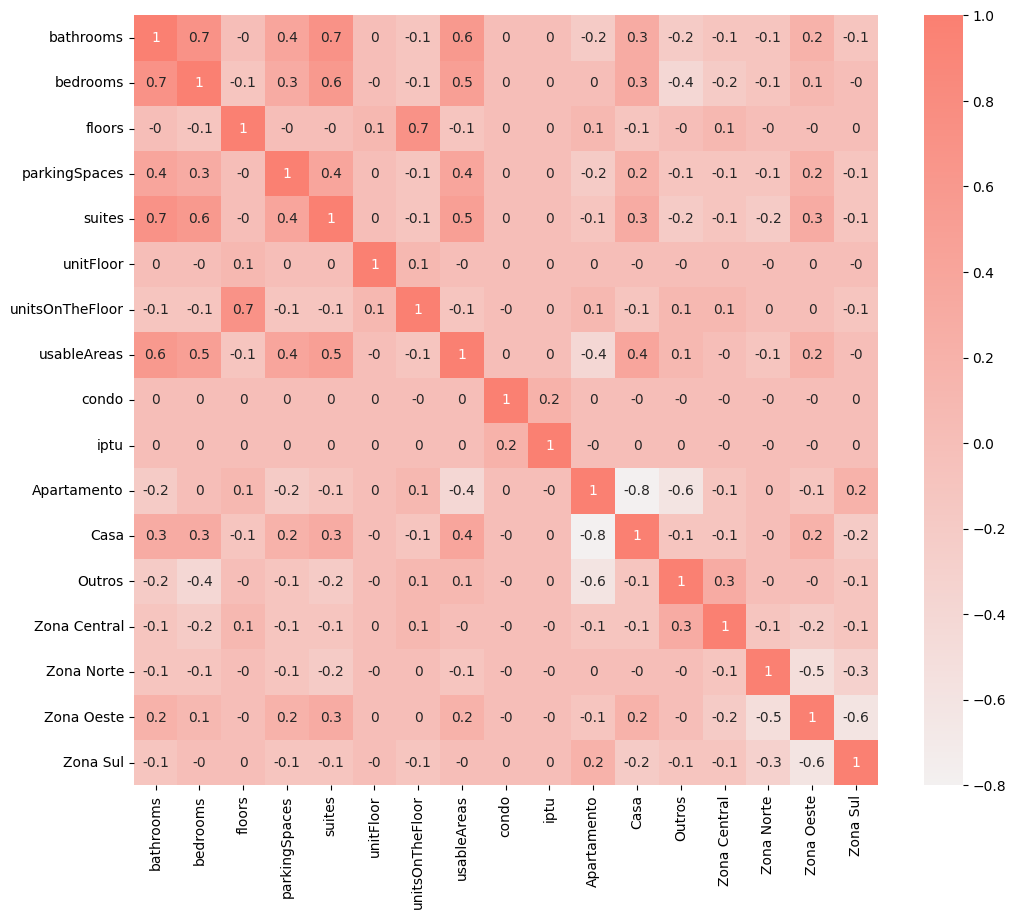

In [ ]:
plt.figure(figsize=(12,10))
color = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(dataframe_correlation.round(1), annot=True, cmap=color)

# Adjust and predict model

In [ ]:
train, test = data_set_prep.randomSplit([0.7, 0.3], seed=101)

In [ ]:
train.count()

51324

In [ ]:
test.count()

22126

## Linear Regression

Linear regression is a model that summarizes the data to a linear function, f(x)= ax + b, where ax is a term that depends on our columns, that is, each column will contribute a little to it. The b is an independent term and refers to the minimum value of a property, even when all columns are represented by zero.



Here we are creating the Linear Regression model

In [ ]:
lr = LinearRegression()

Here we are adjusting the lr model with our train data

In [ ]:
model_lr = lr.fit(train)

Here we are creating our predicted datas

In [ ]:
predicted_lr_train = model_lr.transform(train)

In [ ]:
predicted_lr_train.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 560499.7981843911|
|(17,[0,1,2,3,4,5,...|500000.0|1166054.9861659498|
|(17,[0,1,2,3,4,5,...|308615.0| 190212.2050590142|
|(17,[0,1,2,3,4,5,...|279000.0| 191967.9568849082|
|(17,[0,1,2,3,4,5,...|545000.0| 366885.1496882401|
|(17,[0,1,2,3,4,5,...|449000.0|  439088.490880688|
|(17,[0,1,2,3,4,5,...|479000.0| 442954.9893820426|
|(17,[0,1,2,3,4,5,...|420000.0| 744858.3284430248|
|(17,[0,1,2,3,4,5,...|265000.0| 529019.2203301797|
|(17,[0,1,2,3,4,5,...|490000.0| 826959.0346277542|
|(17,[0,1,2,3,4,5,...|650000.0| 647996.8370044273|
|(17,[0,1,2,3,4,5,...|379900.0| 487601.5105713504|
|(17,[0,1,2,3,4,5,...|449000.0| 777195.0791989593|
|(17,[0,1,2,3,4,5,...|190000.0| 451693.1196279866|
|(17,[0,1,2,3,4,5,...|896000.0| 597364.1931469669|
|(17,[0,1,2,3,4,5,...|679000.0| 844132.1009253846|
|(17,[0,1,2,3,4,5,...|620000.0|

## Metrics to evaluate our lr model

The `R2` refers to how much the model fits the data, that is, how much it reflects the reality of the data.

The `RMSE` is the average squared error and then we calculate the root of everything to verify a metric that evaluates the errors of the model and not the model itself.

In [ ]:
resume_train = model_lr.summary

In [ ]:
resume_train.r2

0.640788699202807

It means that the adjust of the model to our data is about 64%

In [ ]:
resume_train.rootMeanSquaredError

825427.8413403697

Doing the same thing with test data

In [ ]:
resume_test = model_lr.evaluate(test)

In [ ]:
resume_test.r2

0.6288737976447805

In [ ]:
resume_test.rootMeanSquaredError

856029.6710700649

In [ ]:
print('Linear Regression')
print("="*30)
print("Train data")
print("="*30)
print("R²: %f" % resume_train.r2)
print("RMSE: %f" % resume_train.rootMeanSquaredError)
print("")
print("="*30)
print("Test data")
print("="*30)
print("R²: %f" % resume_test.r2)
print("RMSE: %f" % resume_test.rootMeanSquaredError)


Linear Regression
Train data
R²: 0.640789
RMSE: 825427.841340

Test data
R²: 0.628874
RMSE: 856029.671070


## Decision tree model

The Decision Tree model shows how the decision tree works for regression. First, there is an initial decision or initial node that we also call the root: n_rooms > 5. Next, there are two possibilities: the property can have more or less than five rooms.

Depending on these possibilities, we will fall into another conditional, in this case, if the area is greater than twelve hundred, area > 1200, or if the number of bathrooms is greater than 7, n_bathrooms > 7. This part, we call sub- node or branch. As we go through these decisions, at the end, we will have the regression value, the value of this property, which we call the leaf or terminal node.

In [ ]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [ ]:
model_dtr = dtr.fit(train)

In [ ]:
predicted_dtr_train = model_dtr.transform(train)

In [ ]:
predicted_dtr_train.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...|500000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|308615.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...|279000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...|545000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|449000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|479000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|420000.0| 795307.4905239688|
|(17,[0,1,2,3,4,5,...|265000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|490000.0| 795307.4905239688|
|(17,[0,1,2,3,4,5,...|650000.0| 656752.9867498052|
|(17,[0,1,2,3,4,5,...|379900.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|449000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...|190000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...|896000.0| 656752.9867498052|
|(17,[0,1,2,3,4,5,...|679000.0|1072315.8616056433|
|(17,[0,1,2,3,4,5,...|620000.0|

## Metrics to evaluate our dtr model

In [ ]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(predicted_dtr_train, {evaluator.metricName: 'r2'}))
print(evaluator.evaluate(predicted_dtr_train, {evaluator.metricName: 'rmse'}))

0.7806009867408272
645091.6980365565


In [ ]:
predicted_dtr_test = model_dtr.transform(test)

In [ ]:
predicted_dtr_test.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...| 350000.0| 795307.4905239688|
|(17,[0,1,2,3,4,5,...| 340000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...| 430000.0| 607333.6085738302|
|(17,[0,1,2,3,4,5,...| 600000.0| 607333.6085738302|
|(17,[0,1,2,3,4,5,...| 439000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...| 333000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...| 948000.0| 656752.9867498052|
|(17,[0,1,2,3,4,5,...| 459600.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...| 447600.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...| 360000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...| 407000.0|487496.36237785016|
|(17,[0,1,2,3,4,5,...| 310000.0|340333.91761115956|
|(17,[0,1,2,3,4,5,...|1400000.0|1072315.8616056433|
|(17,[0,1,2,3,4,5,...|1180000.0|1072315.8616056433|
|(17,[0,1,2,3,4,5,...|1299500.0|1072315.8616056433|
|(17,[0,1,2,

In [ ]:
print('Decision Tree Regression')
print("="*30)
print("Train data")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_dtr_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_dtr_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Test data")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_dtr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_dtr_test, {evaluator.metricName: "rmse"}))


Decision Tree Regression
Train data
R²: 0.780601
RMSE: 645091.698037

Test data
R²: 0.765412
RMSE: 680582.757105


## Random forest regression

This model is ensemble, which means that it combines one or several machine learning techniques to do the regression in a more complex and efficient way.

Random Forest works with several decision trees. Our data will pass through each of these trees and, in the end, we will have several different results and we will enter a voting phase

This voting phase is usually more specific when working with ranking models.
Let's imagine that our data went through all the regression trees — which are decision trees for regression — and, in the end, we have several property values that each one of them predicted.

We'll take all these values and average them. The result, that is, the prediction of this Random Forest model is an average of all the decision trees that generated different results (trees that attributed different weights to the explanatory variables).

In [ ]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [ ]:
model_rfr = rfr.fit(train)

In [ ]:
predicted_rfr_train = model_rfr.transform(train)

In [ ]:
predicted_rfr_train.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 346051.9498722182|
|(17,[0,1,2,3,4,5,...|500000.0| 467673.8222067874|
|(17,[0,1,2,3,4,5,...|308615.0| 368559.2755293709|
|(17,[0,1,2,3,4,5,...|279000.0| 368559.2755293709|
|(17,[0,1,2,3,4,5,...|545000.0|436464.46354777616|
|(17,[0,1,2,3,4,5,...|449000.0| 461564.2702914601|
|(17,[0,1,2,3,4,5,...|479000.0| 448314.2997879127|
|(17,[0,1,2,3,4,5,...|420000.0|  829968.208472768|
|(17,[0,1,2,3,4,5,...|265000.0|460200.74061624537|
|(17,[0,1,2,3,4,5,...|490000.0|  842349.730314248|
|(17,[0,1,2,3,4,5,...|650000.0| 655553.9151316526|
|(17,[0,1,2,3,4,5,...|379900.0|446950.77011269797|
|(17,[0,1,2,3,4,5,...|449000.0| 422581.0504403743|
|(17,[0,1,2,3,4,5,...|190000.0| 387437.6223972309|
|(17,[0,1,2,3,4,5,...|896000.0| 655553.9151316526|
|(17,[0,1,2,3,4,5,...|679000.0| 872354.8245077856|
|(17,[0,1,2,3,4,5,...|620000.0|

## Metrics to evaluate our rfr model

In [ ]:
print('='*20)
print(f'r2: ', evaluator.evaluate(predicted_rfr_train, {evaluator.metricName: 'r2'}))
print('='*20)
print(f'rmse: ', evaluator.evaluate(predicted_rfr_train, {evaluator.metricName: 'rmse'}))
print('='*20)

r2:  0.7894136580479577
rmse:  632003.1139579864


In [ ]:
predicted_rfr_test = model_rfr.transform(test)

In [ ]:
predicted_rfr_test.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 368559.2755293709|
|(17,[0,1,2,3,4,5,...| 350000.0|  842349.730314248|
|(17,[0,1,2,3,4,5,...| 340000.0| 594611.7162161029|
|(17,[0,1,2,3,4,5,...| 430000.0| 594611.7162161029|
|(17,[0,1,2,3,4,5,...| 600000.0| 587871.6545437505|
|(17,[0,1,2,3,4,5,...| 439000.0|469382.73628186464|
|(17,[0,1,2,3,4,5,...| 333000.0| 387437.6223972309|
|(17,[0,1,2,3,4,5,...| 948000.0| 655553.9151316526|
|(17,[0,1,2,3,4,5,...| 459600.0| 387437.6223972309|
|(17,[0,1,2,3,4,5,...| 447600.0| 387437.6223972309|
|(17,[0,1,2,3,4,5,...| 360000.0| 387437.6223972309|
|(17,[0,1,2,3,4,5,...| 407000.0| 606461.5524562395|
|(17,[0,1,2,3,4,5,...| 310000.0| 433441.8067236291|
|(17,[0,1,2,3,4,5,...|1400000.0|1488179.1239470425|
|(17,[0,1,2,3,4,5,...|1180000.0|1488179.1239470425|
|(17,[0,1,2,3,4,5,...|1299500.0|1169213.7603849554|
|(17,[0,1,2,

In [ ]:
print('Random Forest Regression')
print("="*30)
print("Train data")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_rfr_train, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_rfr_train, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Test data")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_rfr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_rfr_test, {evaluator.metricName: "rmse"}))


Random Forest Regression
Train data
R²: 0.789414
RMSE: 632003.113958

Test data
R²: 0.777123
RMSE: 663376.875732


# Optmization techniques

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

## Cross validation Decision Tree

In [ ]:
dtr

DecisionTreeRegressor_5b2d86aa7dbf

This are the parameters that I want the model run some tests.

In [ ]:
grid = ParamGridBuilder() \
  .addGrid(dtr.maxDepth, [2, 5, 10]) \
  .addGrid(dtr.maxBins, [10, 32, 45]) \
  .build()

The `ParamGridBuilder` method defines a grid with the parameters that will be used to test the model when performing cross validation.

In [ ]:
evaluator

RegressionEvaluator_a6e53a8a4d3c

In [ ]:
dtr_cv = CrossValidator(
    estimator = dtr,
    estimatorParamMaps=grid,
    evaluator = evaluator,
    numFolds = 3,
    seed = 101
)

In [ ]:
model_dtr_cv = dtr_cv.fit(train)

In [ ]:
predicted_dtr_cv_test = model_dtr_cv.transform(test)

In [ ]:
print('Decision Tree Regression')
print("="*30)
print("="*30)
print("Whithout Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_dtr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_dtr_test, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_dtr_cv_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_dtr_cv_test, {evaluator.metricName: "rmse"}))


Decision Tree Regression
Whithout Cross Validation
R²: 0.765412
RMSE: 680582.757105

Cross Validation
R²: 0.780736
RMSE: 657979.195875


## Cross validation Random Forest

In [ ]:
rfr

RandomForestRegressor_69018f71bafd

In [ ]:
grid = ParamGridBuilder() \
  .addGrid(rfr.numTrees, [10, 20, 30]) \
  .addGrid(rfr.maxDepth, [5, 10]) \
  .addGrid(rfr.maxBins, [10, 32, 45]) \
  .build()

In [ ]:
evaluator

RegressionEvaluator_a6e53a8a4d3c

In [ ]:
rfr_cv = CrossValidator (
    estimator = rfr,
    estimatorParamMaps = grid,
    evaluator = evaluator,
    numFolds = 3
)

In [ ]:
model_rfr_cv = rfr_cv.fit(train)

In [ ]:
predicted_rfr_cv_test = model_rfr_cv.transform(test)

In [ ]:
print('Random Forest Regression')
print("="*30)
print("Whithout Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_rfr_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_rfr_test, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(predicted_rfr_cv_test, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(predicted_rfr_cv_test, {evaluator.metricName: "rmse"}))


Random Forest Regression
Whithout Cross Validation
R²: 0.777123
RMSE: 663376.875732

Cross Validation
R²: 0.818451
RMSE: 598721.337369


# Predicting results using the best model

In [ ]:
data_set.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo|  iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+------+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|   0.0|          0|   0|     1|           0|         0|         1|       0|


In [ ]:
# explanation variables
X

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [ ]:
new_house = [{
    'bathrooms': 2,
    'bedrooms': 2,
    'floors': 2,
    'parkingSpaces': 1,
    'suites': 1,
    'unitFloor':0,
    'unitsOnTheFloor':0,
    'usableAreas':200,
    'condo':200,
    'iptu':0,
    'Apartamento':0,
    'Casa':1,
    'Outros':0,
    'Zona Central':0,
    'Zona Norte':0,
    'Zona Oeste':0,
    'Zona Sul':1,
        'label': 0}]


In [ ]:
new_house = spark.createDataFrame(new_house)

In [ ]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [ ]:
my_house_vectorized = assembler.transform(new_house).select('features', 'label')

In [ ]:
my_house_vectorized.show(truncate=False)

+--------------------------------------------------------------------+-----+
|features                                                            |label|
+--------------------------------------------------------------------+-----+
|(17,[0,1,2,3,4,7,8,11,16],[2.0,2.0,2.0,1.0,1.0,200.0,200.0,1.0,1.0])|0    |
+--------------------------------------------------------------------+-----+



In [ ]:
model_rfr_cv.transform(my_house_vectorized).show(truncate=False)

+--------------------------------------------------------------------+-----+------------------+
|features                                                            |label|prediction        |
+--------------------------------------------------------------------+-----+------------------+
|(17,[0,1,2,3,4,7,8,11,16],[2.0,2.0,2.0,1.0,1.0,200.0,200.0,1.0,1.0])|0    |2266756.2946602134|
+--------------------------------------------------------------------+-----+------------------+



Initially, we analyzed and preprocessed the data, selecting relevant features and addressing data issues. This was followed by exploratory data analysis to identify relationships, leading us to employ regression models like Linear Regression and Decision Trees. Additionally, we explored ensemble models like Random Forest, assessing their performance using various metrics and techniques such as Cross Validation. Through this process, we established that our models were effective. Ultimately, we employed the best model for real-world predictions, considering its application in scenarios like property investment or cost estimation based on house features.